# Classifição de Solos.

## Objectivo

O objectivo é de criar um modelo com a deep learning que pode ser usado para facilitar o trabalho de camponês em áreas de grandes hectares de forma mais eficiente.

Isto requer que o modelo atinga uma acúracia de pelos 85% ou mais e tenha uma boa precisão.

### 1. Importar as bibliotecas necessarias

In [1]:
# importaçao das Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"

import warnings
warnings.filterwarnings('ignore')
import pathlib

from zipfile import ZipFile
import PIL

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
import tensorflow as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout,Dense, Flatten, Activation, BatchNormalization, Conv2D, Dense, Dropout, MaxPooling2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


### 2. Carregar as imagens de treino e o dataset de validacao
#### i. Pegar o directorio do dataset de imagens

In [2]:
#directorio de treino e teste
train_dataset_path=pathlib.Path('dataset/train')
validation_dataset_path=pathlib.Path('dataset/test')

#### ii. Carregar as imagens do datase e aplicaco aumentacao

In [3]:
BATCH_SIZE=32
IMG_HEIGHT=150
IMG_WIDTH=150

In [5]:
# aumentacao...imagens e classes que pertencem
ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   fill_mode='nearest')
                                   
train_generator = train_datagen.flow_from_directory(
    train_dataset_path, 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)


Found 9558 images belonging to 4 classes.


In [6]:
# Carregar dataset de validacao
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)


Found 2894 images belonging to 4 classes.


In [7]:
train_steps = np.ceil(train_generator.samples // train_generator.batch_size)
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
print(train_steps)
print(val_steps)

298.0
91.0


#### iii. Pegar as labels de mapeamento

In [8]:
labels={value:key for key, value in train_generator.class_indices.items()}

print("Mapeamento das Labels para classes presente no dataset de treino e validacao\n")
for key, value in labels.items():
    print(f"{key}:{value}")

Mapeamento das Labels para classes presente no dataset de treino e validacao

0:Alluvial soil
1:Black Soil
2:Clay soil
3:Red soil


### 3. Traçar Grafico Amostra de Imagens de Treino

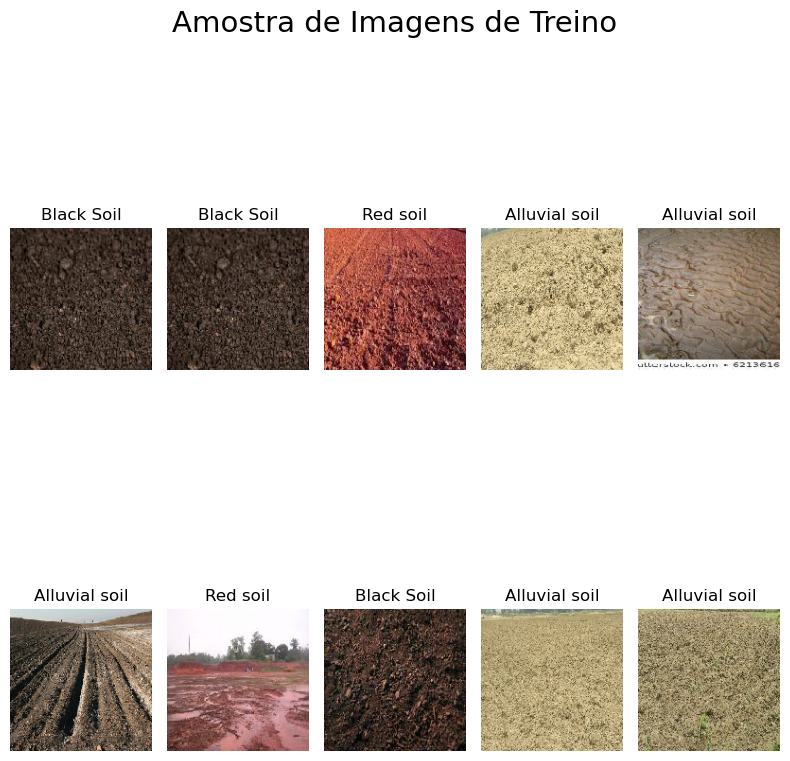

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(8, 10))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx+=1

plt.tight_layout()
plt.suptitle("Amostra de Imagens de Treino",fontsize=21)
plt.savefig("Amostra-de-Imagens-de-Treino.png")
plt.show()


### 4. Treinar o Modelo

#### i. Criar o modelo

In [25]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(),
        Conv2D(filters=64,kernel_size=(3,3),padding='valid',kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(),
        Conv2D(filters=32,kernel_size=(3,3),padding='valid',kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(),
        Flatten(),
        Dense(units=256,activation='relu'),
        Dropout(0.5),
        Dense(len(labels),activation='softmax')
        ])
        
    return model

In [26]:
cnn_model=create_model()

In [27]:
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 146, 146, 128)     9728      
                                                                 
 activation_3 (Activation)   (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 73, 73, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 73, 73, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_4 (Activation)   (None, 71, 71, 64)       

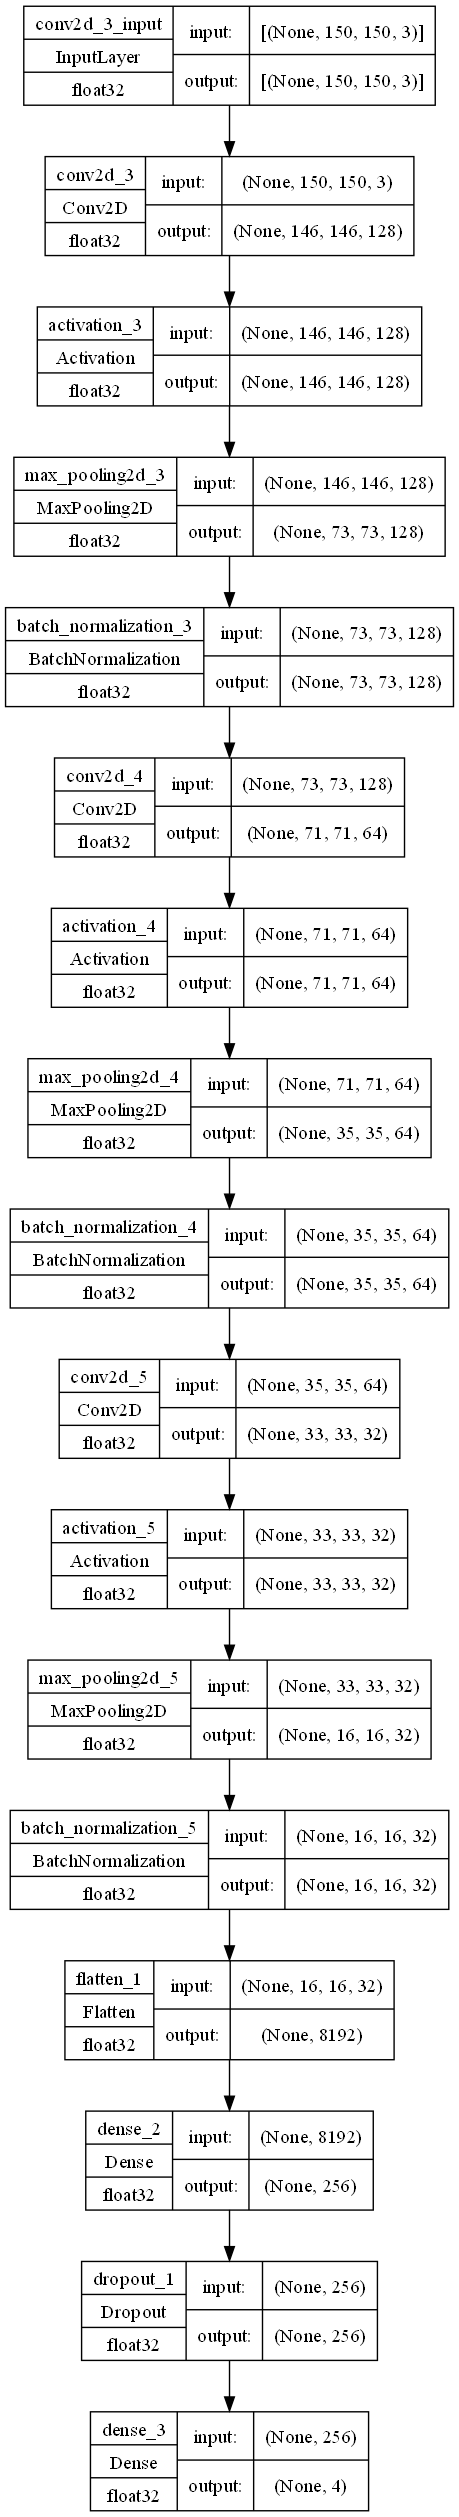

In [28]:
#representacao grafica das camadas do modelo
import tensorflow as tf

tf.keras.utils.plot_model(
  cnn_model, to_file='img_model.png', show_dtype=True, dpi=100, show_shapes=True, expand_nested=False)

#### ii. Definindo callbacks

In [29]:
#reduzir a taxa de aprendizagem com Plateau.
#Reduzir a taxa de aprendizagem quando as metricas param de melhorar.
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=np.sqrt(0.1),patience=5) 

#### iii. Definindo o optmizador

In [30]:
optimizer=Adam(learning_rate=0.001)

#### iv. Compilar o modelo

In [31]:
cnn_model.compile(optimizer=optimizer,loss=CategoricalCrossentropy(),metrics=['accuracy'])

#### v. Treinar o modelo

In [32]:
history = cnn_model.fit(
    train_generator, 
    epochs=120,
    steps_per_epoch=20,
    validation_data=validation_generator,
    validation_steps=25,
    verbose=1, 
    callbacks=[reduce_lr])


Epoch 1/120
20/20 [==============================] - 137s 6s/step - loss: 2.3613 - accuracy: 0.7141 - val_loss: 3.4283 - val_accuracy: 0.2075 - lr: 0.0010
Epoch 2/120
20/20 [==============================] - 90s 4s/step - loss: 2.5821 - accuracy: 0.7516 - val_loss: 3.1584 - val_accuracy: 0.2037 - lr: 0.0010
Epoch 3/120
20/20 [==============================] - 88s 4s/step - loss: 2.5498 - accuracy: 0.7719 - val_loss: 3.3615 - val_accuracy: 0.5587 - lr: 0.0010
Epoch 4/120
20/20 [==============================] - 86s 4s/step - loss: 2.0009 - accuracy: 0.7781 - val_loss: 1.7998 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 5/120
20/20 [==============================] - 87s 4s/step - loss: 1.4436 - accuracy: 0.7969 - val_loss: 4.2696 - val_accuracy: 0.2488 - lr: 0.0010
Epoch 6/120
20/20 [==============================] - 93s 5s/step - loss: 1.4688 - accuracy: 0.7781 - val_loss: 5.3703 - val_accuracy: 0.3900 - lr: 0.0010
Epoch 7/120
20/20 [==============================] - 87s 4s/step - loss: 1.

### 5. Traçar Gráfico das Métricas do Modelo

#### i. Traçar o gráfico da acurácia, perdas e taxa de aprendizagem no treino e validacao

In [33]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']


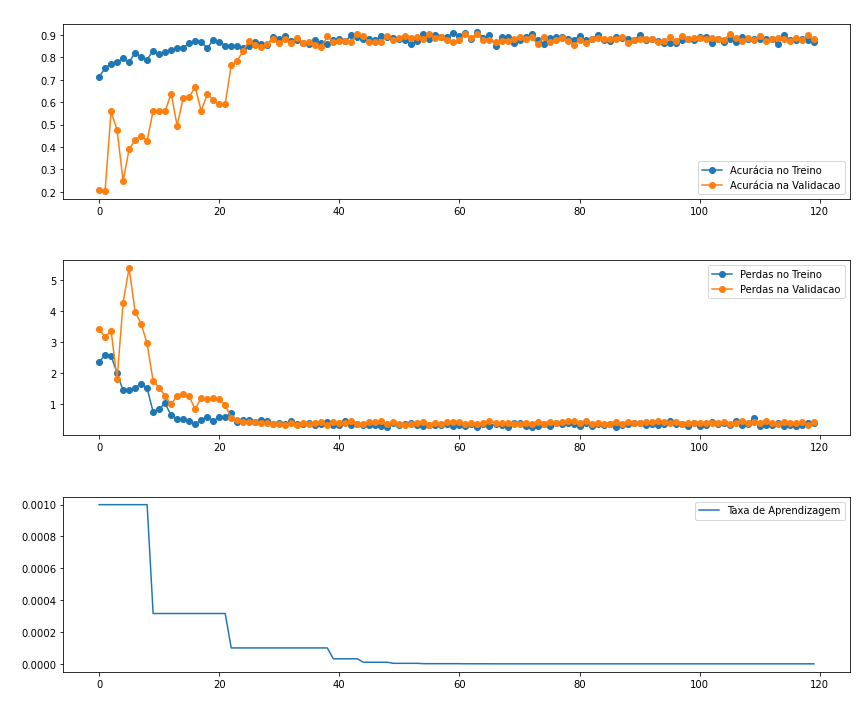

In [36]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))
ax[0].set_title("Acurácia no Treino vs. Épocas")
ax[0].plot(train_accuracy, 'o-', label='Acurácia no Treino')
ax[0].plot(val_accuracy, 'o-', label='Acurácia na Validacao')
ax[0].set_xlabel('Épocas')
ax[0].set_ylabel('Acurácia')
ax[0].legend(loc='best')


ax[1].set_title("Perdas no Treino/Validacao vs. Épocas")
ax[1].plot(train_loss, 'o-', label='Perdas no Treino')
ax[1].plot(val_loss, 'o-', label='Perdas na Validacao')
ax[1].set_xlabel('Épocas')
ax[1].set_ylabel('Perda')
ax[1].legend(loc='best')


ax[2].set_title("Taxa de Aprendizagem no Treino vs. Épocas")
ax[2].plot(learning_rate, label='Taxa de Aprendizagem')
ax[2].set_xlabel('Épocas')
ax[2].set_ylabel('Perda')
ax[2].legend(loc='best')

plt.tight_layout()
plt.savefig("gráfico-da-acurácia-perdas-e-taxa-de-aprendizagem-no-treino-e-validacao.png")
plt.show()

In [37]:
#salvar o modelo para testes"
cnn_model.save("soil-detention-120-epochs.h5")

### 6. Testar o Modelo no Dataset do Teste

In [38]:
#testar o modelo no dataset de validacao, o teste
test_dataset=pathlib.Path('dataset/Test')

In [39]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='categorical'
)


Found 1803 images belonging to 4 classes.


### 7. Modelo de Previsao no Dataset de Test

In [40]:
predictions=cnn_model.predict(test_generator)

57/57 [==============================] - 83s 1s/step


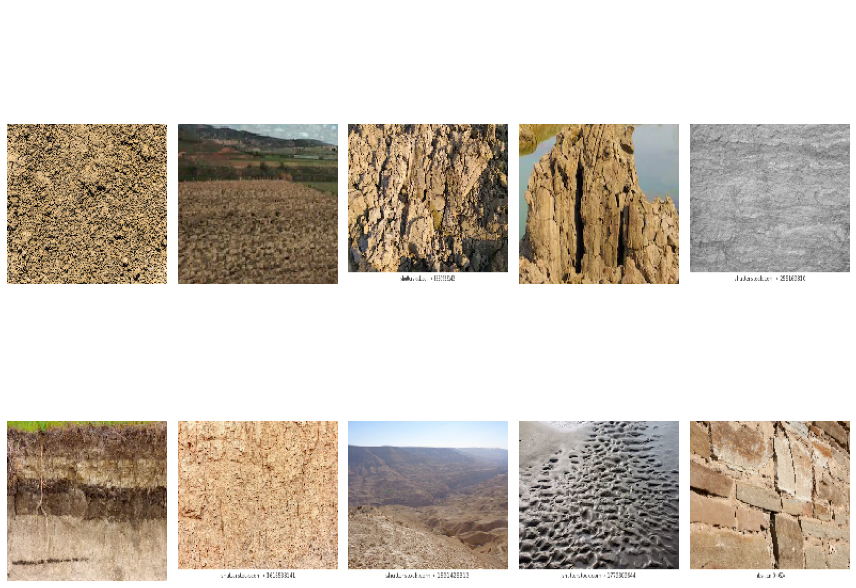

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Previsao Dataset no Teste",fontsize=2)
plt.savefig("Previsao-Dataset-no-Teste.png")
plt.show()


In [42]:
test_loss,test_accuracy=cnn_model.evaluate(test_generator,batch_size=BATCH_SIZE)

57/57 [==============================] - 58s 1s/step - loss: 0.4035 - accuracy: 0.8835


In [43]:
print(f"Perdas no teste: {test_loss}")
print(f"Acurária no teste: {test_accuracy}")

Perdas no teste: 0.40348073840141296
Acurária no teste: 0.8835274577140808


### 8. Traçando Gráfico das Metricas de Classificacao

#### i. Matriz de Confusao

In [44]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

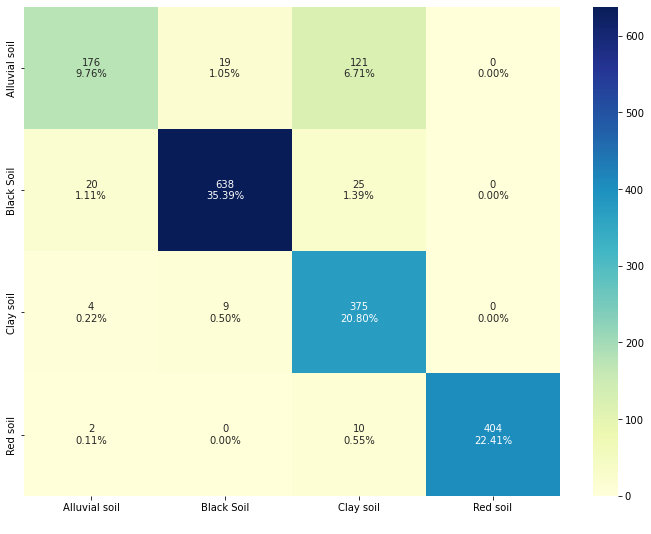

In [45]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts=["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages=["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels=[f"{v1}\n{v2}" for v1,v2 in zip(group_counts,group_percentages)]
box_labels=np.asarray(box_labels).reshape(4,4)

plt.figure(figsize=(12,9))
sns.heatmap(cf_mtx,xticklabels=labels.values(), yticklabels=labels.values(), cmap='YlGnBu',fmt="",annot=box_labels)
plt.xlabel("Classes Previstas")
plt.xlabel("Classes Verdadeiras")
plt.savefig("matrix-de-confusao.png")
plt.show()

### Calcular a Curva ROC

In [47]:
#carregar o modelo treinado
#Aqui a melhor epoca sera usada.
loaded_model = keras.keras.models.load_model('soil-detention-120-epochs.h5')
loaded_model.compile(loss=CategoricalCrossentropy(),optimizer='adam',metrics=['accuracy'])
#predictions=cnn_model.predict(test_generator)

Valor de ROC AUC:  0.9094990875242628


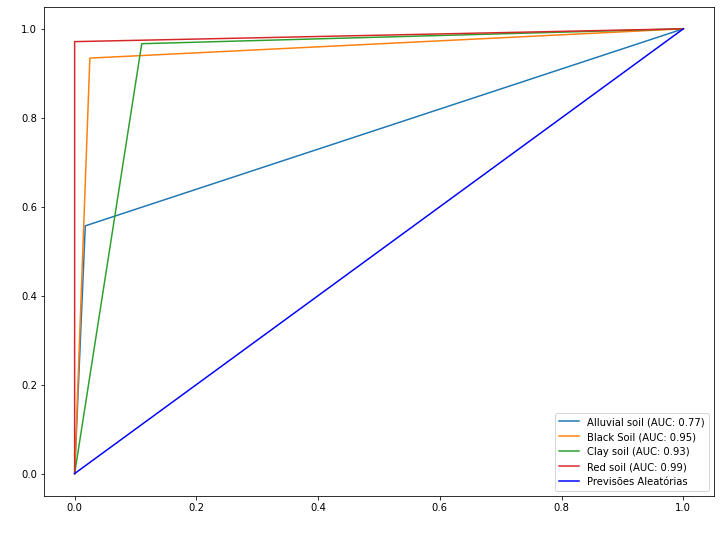

In [49]:
target = labels.values()

# definir o tamanho da figura
fig, c_ax = plt.subplots(1, 1, figsize=(12, 9))

# funcao para calcular a curva roc para multiclasses
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:, idx].astype(int), y_pred[:, idx])
        c_ax.plot(fpr, tpr, label='%s (AUC: %0.2f)' % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label='Previsões Aleatórias')
    return roc_auc_score(y_test, y_pred, average=average)


print("Valor de ROC AUC: ", multiclass_roc_auc_score(y_true, y_pred))
c_ax.legend()
c_ax.set_xlabel('Taxa dos Falsos Positivos')
c_ax.set_ylabel('Taxa dos Verdadeiros Positivos')

plt.savefig("curva-roc-multiclass.png")
plt.show()

In [50]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

               precision    recall  f1-score   support

Alluvial soil       0.87      0.56      0.68       316
   Black Soil       0.96      0.93      0.95       683
    Clay soil       0.71      0.97      0.82       388
     Red soil       1.00      0.97      0.99       416

     accuracy                           0.88      1803
    macro avg       0.88      0.86      0.86      1803
 weighted avg       0.90      0.88      0.88      1803



### 9. Classificacoes Erradas

In [51]:
# vamos ver se o modelo classificou de forma errada
errors = (y_true-y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]


In [52]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]


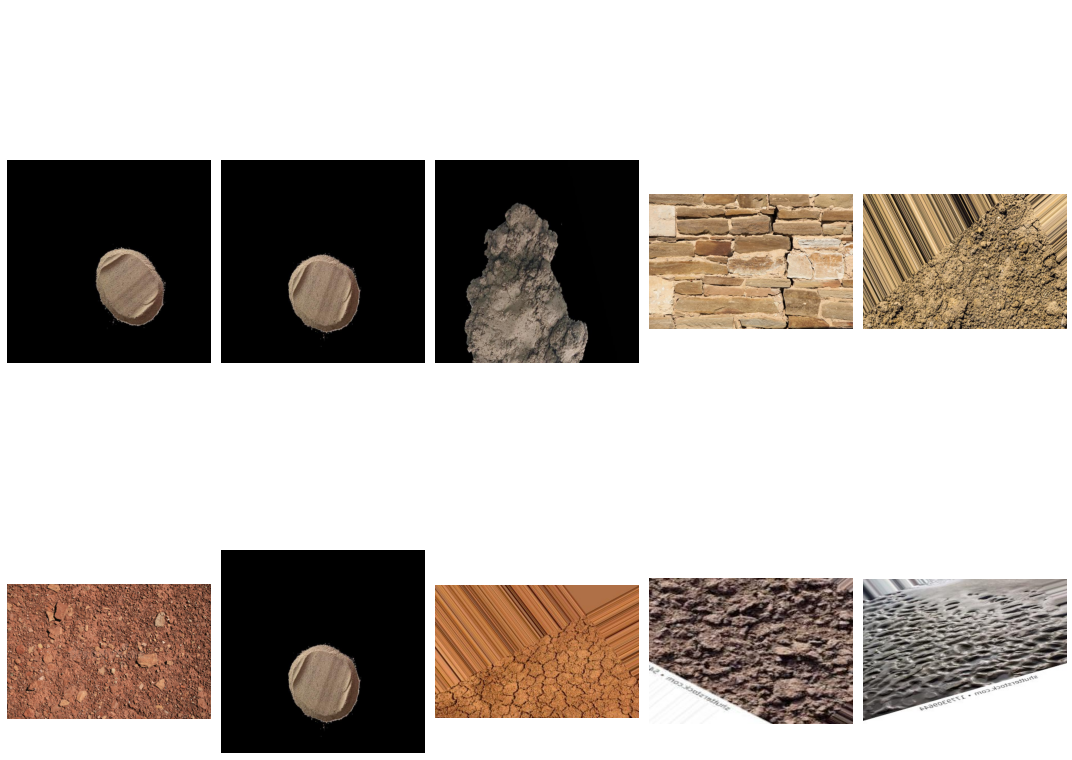

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 13))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]

        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]

        ax[i, j].set_title(f"Label Verdadeira: {true_label}\nLabel Prevista: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i,j].imshow(img)
        ax[i,j].axis("off")

plt.tight_layout()
plt.suptitle("Classificacoes Erradas feitas no teste", fontsize=20)
plt.savefig("Classificacoes-Erradas-feitas-no-teste.png")
plt.show()

####